In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

2023-08-18 18:12:54.512447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 18:12:55.069046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## dataset description

In [2]:
ROOT_URL = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

def read_data(filename):
    data = np.loadtxt(ROOT_URL + filename, delimiter="\t")
    y = data[:,0].astype(int)
    x = data[:,1:]
    
    return x,y


xtr, ytr = read_data("FordA_TRAIN.tsv")
xts, yts = read_data("FordA_TEST.tsv")

print(xtr.shape, ytr.shape, xts.shape, yts.shape)

(3601, 500) (3601,) (1320, 500) (1320,)


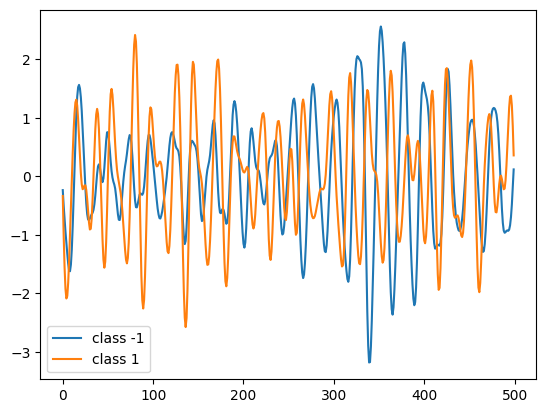

In [3]:
classes = np.unique(np.concatenate((ytr, yts)))

n = 2

for cl in classes:
    cl_data = xtr[ytr == cl]
    plt.plot(cl_data[n], label="class "+str(cl))
plt.legend()
plt.show()

In [4]:
# reshape into multivariate value
xtr = xtr.reshape((xtr.shape[0],xtr.shape[1],1))
xts = xts.reshape((xts.shape[0],xts.shape[1],1))
print(xtr.shape, xts.shape)

# shuffle
idx = np.random.permutation(xtr.shape[0])
xtr, ytr = xtr[idx], ytr[idx]

# labels tp positive ints
ytr[ytr == -1] = 0
yts[yts == -1] = 0


(3601, 500, 1) (1320, 500, 1)


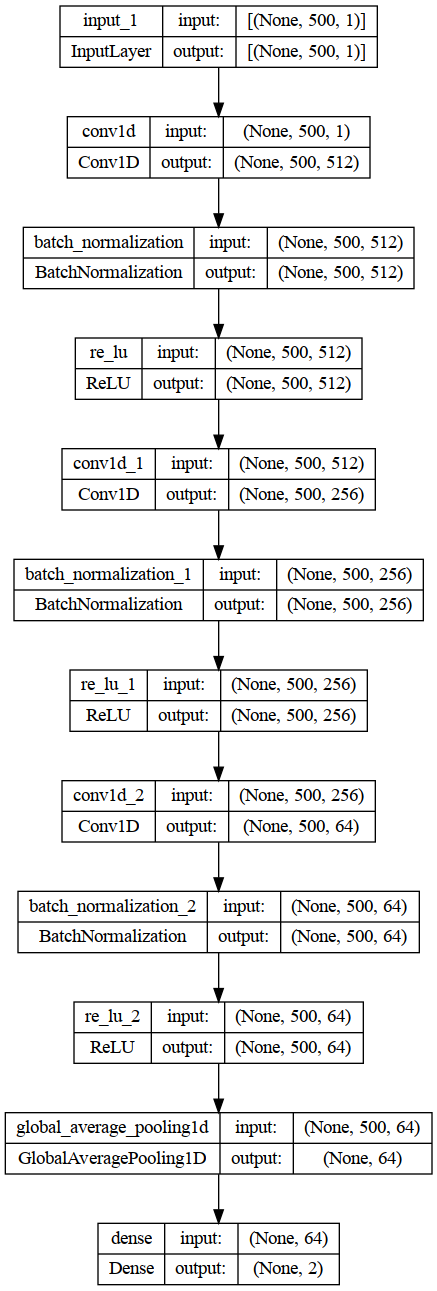

In [5]:
def build_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    ouput_layer = keras.layers.Dense(len(classes), activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=ouput_layer)

model = build_model(input_shape=xtr.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [6]:
epochs = 30
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

history = model.fit(
    xtr, ytr,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
90/90 [==============================] - 24s 252ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.6649 - val_loss: 0.6923 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 2/30
90/90 [==============================] - 22s 241ms/step - loss: 0.4842 - sparse_categorical_accuracy: 0.7635 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 3/30
90/90 [==============================] - 30s 334ms/step - loss: 0.4550 - sparse_categorical_accuracy: 0.7705 - val_loss: 0.6929 - val_sparse_categorical_accuracy: 0.5173 - lr: 0.0010
Epoch 4/30
90/90 [==============================] - 36s 399ms/step - loss: 0.4296 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.5201 - lr: 0.0010
Epoch 5/30
90/90 [==============================] - 37s 409ms/step - loss: 0.4257 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.6058 - val_sparse_categorical_accuracy: 0.7157 - lr: 0.0010
Epoch 6/30
90/90 [============

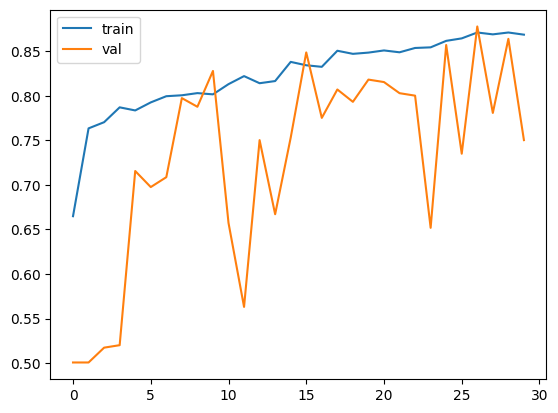

In [7]:
metric = "sparse_categorical_accuracy"
history.history.keys()
plt.plot(history.history[metric])
plt.plot(history.history["val_"+metric])
plt.legend(["train", "val"])
plt.show()

In [8]:
model.evaluate(xts, yts, verbose=1)

42/42 [==============================] - 4s 84ms/step - loss: 0.4200 - sparse_categorical_accuracy: 0.7455


[0.4200020432472229, 0.7454545497894287]